# Benchmark and Repositories

In [1]:
import networkx as nx
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt

import os
import sys

sys.path.append(f"{os.getcwd()}/..")

from utils import draw_graph, FIGURES_DIR, DATA_DIR

### Simple Example of Graphs

We start with some simple graphs

In [2]:
complete = nx.complete_graph(n=7)
lollipop = nx.lollipop_graph(m=7, n=3)
barbell = nx.barbell_graph(m1=7, m2=4)

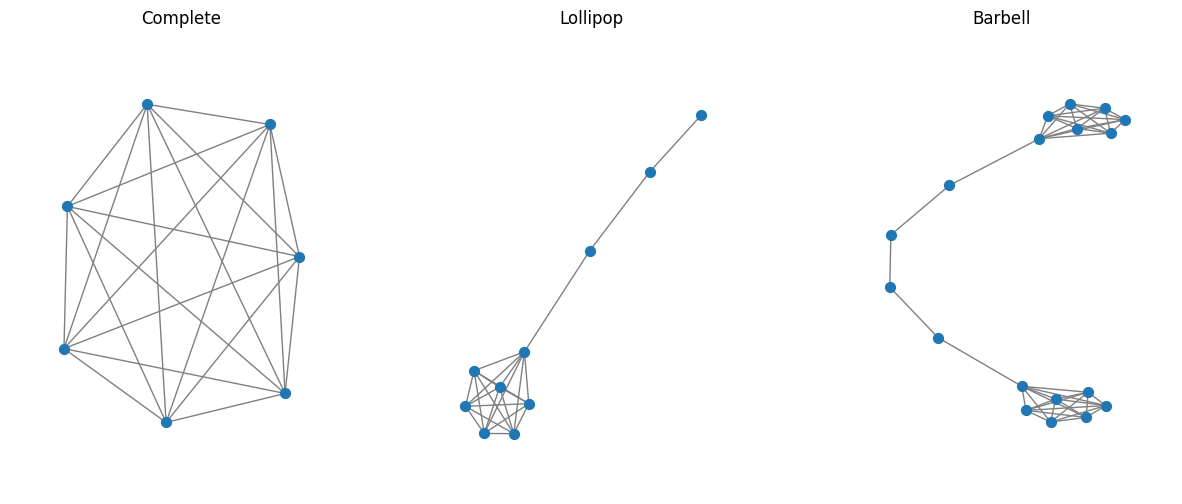

In [3]:
plt.figure(figsize=(15,6))
plt.subplot(1,3,1)
draw_graph(complete)
plt.title("Complete")
plt.subplot(1,3,2)
plt.title("Lollipop")
draw_graph(lollipop)
plt.subplot(1,3,3)
plt.title("Barbell")
draw_graph(barbell)
plt.savefig(FIGURES_DIR / "SimpleGraphs.png")

In [4]:
complete = nx.relabel_nodes(nx.complete_graph(n=7), lambda x: x + 0)
lollipop = nx.relabel_nodes(nx.lollipop_graph(m=7, n=3), lambda x: x+100)
barbell = nx.relabel_nodes(nx.barbell_graph(m1=7, m2=4), lambda x: x+200)

In [5]:
def get_random_node(graph):
    return np.random.choice(graph.nodes)

In [6]:
import numpy as np

## We compose simple graphs into one

In [7]:
allGraphs = nx.compose_all([complete, barbell, lollipop])
allGraphs.add_edge(get_random_node(lollipop), get_random_node(lollipop))
allGraphs.add_edge(get_random_node(complete), get_random_node(barbell))

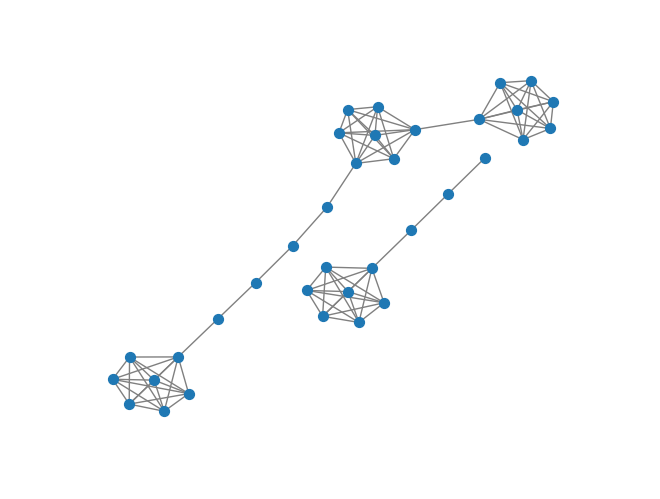

In [8]:
draw_graph(allGraphs, layout=nx.kamada_kawai_layout)

#### Model Barabasi Albert

In the following we create and analyse some simple graph generated by the Barabasi-Albert model 

In [9]:
BA_graph_small = nx.extended_barabasi_albert_graph(n=20,m=1,p=0,q=0)

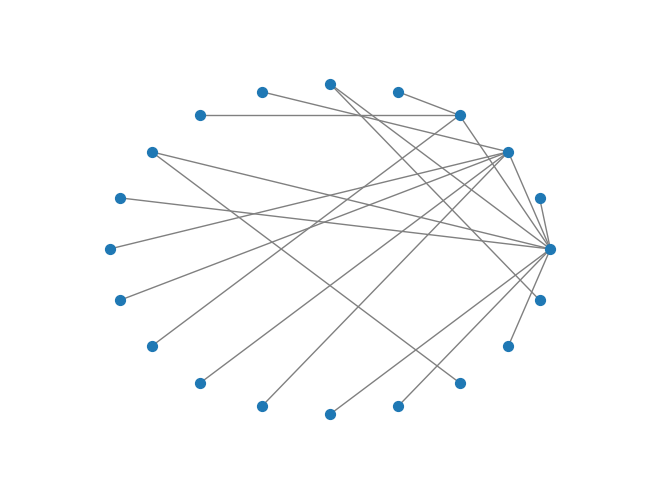

In [10]:
draw_graph(BA_graph_small, layout=nx.circular_layout)

We analyse large Barabasi-Albert graphs to investigate their ability to generate power-law distribution for the degree of node

In [11]:
n = 1E5
bag = nx.extended_barabasi_albert_graph(n,m=1,p=0,q=0)

In [12]:
degree = dict(nx.degree(bag)).values()

In [13]:
bins = np.round(np.logspace(np.log10(min(degree)), np.log10(max(degree)), 10))

In [14]:
from collections import Counter
cnt = Counter(np.digitize(np.array(list(degree)), bins))

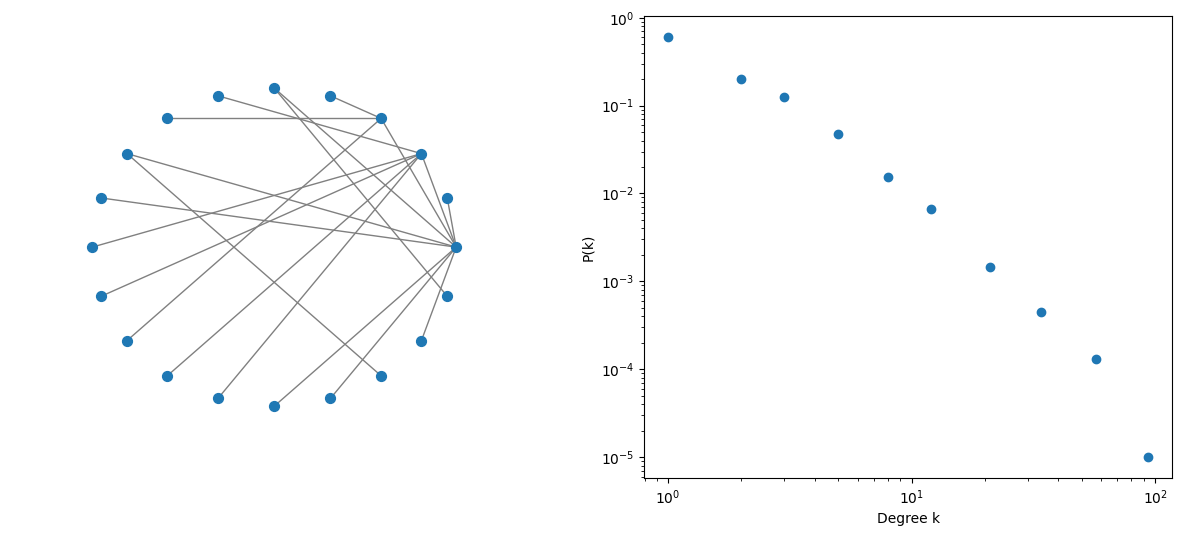

In [15]:
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
draw_graph(BA_graph_small, layout=nx.circular_layout)
plt.subplot(1,2,2)
x, y = list(zip(*[(bins[k-1], v/n) for k, v in cnt.items()]))
plt.plot(x, y, 'o'); plt.xscale("log"); plt.yscale("log")
plt.xlabel("Degree k")
plt.ylabel("P(k)")
plt.savefig(FIGURES_DIR / "Barabasi_Albert.png")

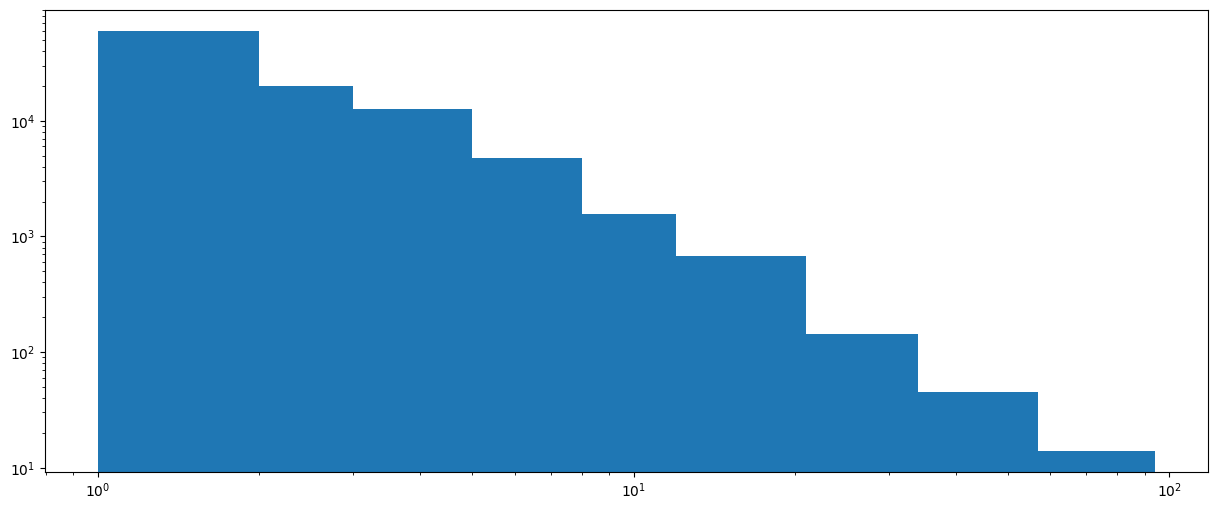

In [16]:
plt.figure(figsize=(15, 6))

plt.hist(degree, bins=bins)
plt.xscale("log")
plt.yscale("log")

Other simple graph Benchmarks

In [17]:
import pandas as pd

In [18]:
graph = nx.florentine_families_graph()

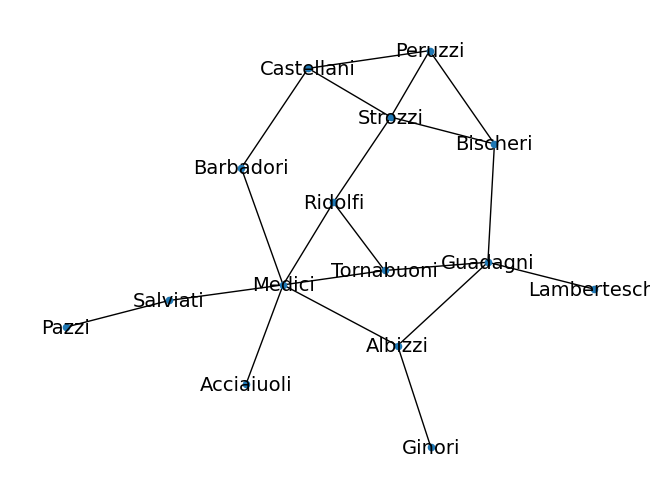

In [19]:
nx.draw_kamada_kawai(graph, with_labels=True, node_size=20, font_size=14)
plt.savefig(FIGURES_DIR / "Florentine.png")

### Benchmarks from the Network Data Repository

This dataset (and other) can be downloaded from http://networkrepository.com/. The datasets are generally in the MTX file format that has been described in the book. 

In particular the dataset here presented is taken from the collaboration network of Arxiv Astro Physics, that can be downloaded from http://networkrepository.com/ca-AstroPh.php.

As better explained in the book, some of the files that can be downloaded from that source are somewhat non-standard and needs small fixes. Please make sure the header of the file has the following 

*%%MatrixMarket matrix coordinate pattern symmetric*

with a double %

In [20]:
import requests
from zipfile import ZipFile
from io import BytesIO
import shutil

url = 'https://nrvis.com/download/data/ca/ca-AstroPh.zip'
filename = DATA_DIR / "ca-AstroPh.mtx"
tmp_dir = DATA_DIR / "tmp"

r = requests.get(url, allow_redirects=True)

myzip = ZipFile(BytesIO(r.content))

tmp_file = myzip.extract(filename.name, path=tmp_dir)

with open(tmp_file, "r") as fid_in:
    with open(filename, "w") as fid_out:
        fid_out.write("%")
        fid_out.write(fid_in.read())

shutil.rmtree(tmp_dir)

In [21]:
from scipy.io import mmread

In [22]:
adj_matrix = mmread(filename)

In [23]:
graph = nx.from_scipy_sparse_array(adj_matrix)

In [24]:
degrees = dict(nx.degree(graph))

In [25]:
ci = nx.clustering(graph)

In [26]:
centrality = nx.centrality.eigenvector_centrality(graph)

In [27]:
stats = pd.DataFrame({
    "centrality": centrality, 
    "C_i": ci, 
    "degree": degrees
})

In [28]:
stats.head()

,centrality,C_i,degree
0,8.901198e-05,0.692137,43
1,3.208282e-10,1.000000,2
2,3.407931e-04,0.242424,12
3,4.290384e-06,0.000000,1
4,6.722036e-07,1.000000,2


Here we provide some simple analysis of the DataFrame we generated to see correlations between centrality, clustering coefficient and degree. 

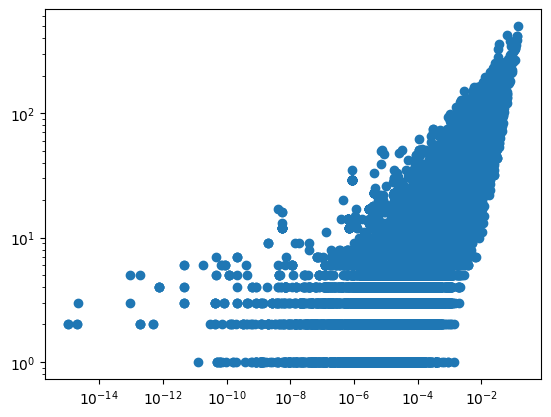

In [29]:
plt.plot(stats["centrality"], stats["degree"], 'o')
plt.xscale("log")
plt.yscale("log")

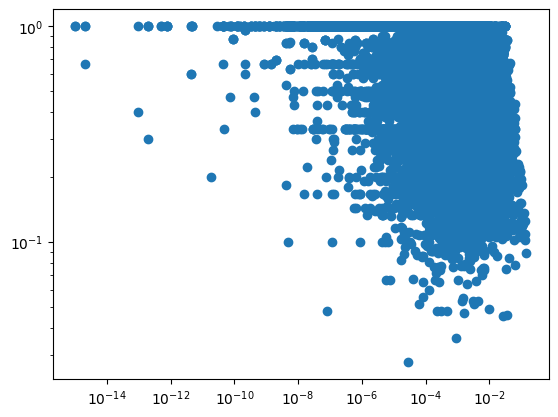

In [30]:
plt.plot(stats["centrality"], stats["C_i"], 'o')
plt.xscale("log")
plt.yscale("log")

### Ego-network 

Here we plot the ego-network of the most-connected node, that has id 6933. However, even this network looks a bit messy since it has hundreds of nodes. We therefore sample randomly or based on centrality/clustering coefficient in order to plot a relevant subgraph.

In [31]:
neighbors = [n for n in nx.neighbors(graph, 6933)]

In [32]:
sampling = 0.1

In [33]:
nTop = round(len(neighbors)*sampling)

In [34]:
idx = {
    "random": stats.loc[neighbors].sort_index().index[:nTop], 
    "centrality": stats.loc[neighbors].sort_values("centrality", ascending=False).index[:nTop],
    "C_i": stats.loc[neighbors].sort_values("C_i", ascending=False).index[:nTop]
}

In [35]:
def plotSubgraph(graph, indices, center = 6933):
    draw_graph(
        nx.subgraph(graph, list(indices) + [center]),
        layout = nx.kamada_kawai_layout
    )

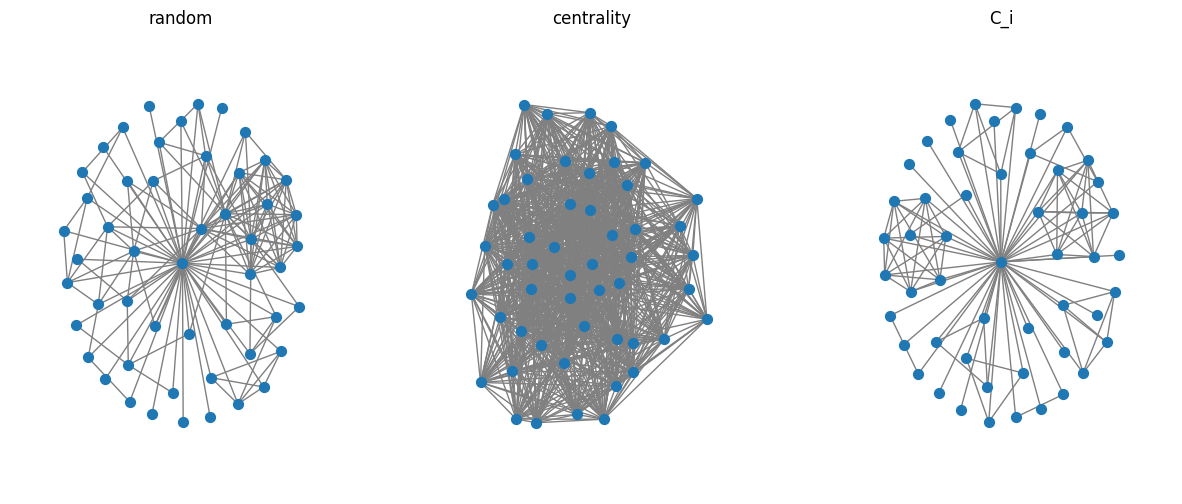

In [36]:
plt.figure(figsize=(15,6))
for ith, title in enumerate(["random", "centrality", "C_i"]):
    plt.subplot(1,3,ith+1)
    plotSubgraph(graph, idx[title])
    plt.title(title)
plt.savefig(FIGURES_DIR / "PhAstro")

### Data to Gephi

Otherwise, we could also export the data from networkx in order to plot it and analyse it using the Gephi software.

In [37]:
nx.write_gexf(graph, DATA_DIR / 'ca-AstroPh.gexf')

### Bipartite Graphs

In [38]:
n=10

n_nodes = 10
n_edges = 12

bottom_nodes = [ith for ith in range(n) if int(ith) % 2 == 0]
top_nodes = [ith for ith in range(n) if int(ith) % 2 == 1.0]

In [39]:
iter_edges = zip(np.random.choice(bottom_nodes, n_edges), np.random.choice(top_nodes, n_edges))

edges = pd.DataFrame([{"source": a, "target": b} for a, b in iter_edges])

In [40]:
B = nx.Graph()

B.add_nodes_from(bottom_nodes, bipartite=0)
B.add_nodes_from(top_nodes, bipartite=1)

In [41]:
B.add_edges_from([tuple(x) for x in edges.values])

In [42]:
from networkx.drawing.layout import bipartite_layout

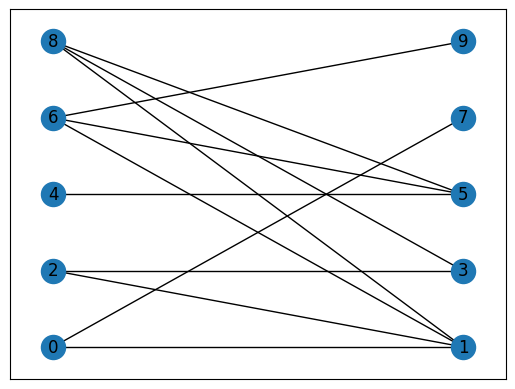

In [43]:
pos = bipartite_layout(B, bottom_nodes)

nx.draw_networkx(B, pos=pos)